# Air Quality

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import time

# Define the base URL for the POST request
url = 'https://data.airquality.nsw.gov.au/api/Data/get_Observations'

# Initialize an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Define the initial start and end dates
start_date = datetime.strptime("2015-04-01", "%Y-%m-%d")
end_date = start_date + timedelta(days=56)

# Set the number of iterations you want to loop through
num_iterations = 63  # Approximate number of iterations to get to today
retries = 3  # Number of retries for failed iterations

# Function to make the API request and process the data
def process_iteration(start_date_str, end_date_str):
    # Construct the payload for each 56-day period
    payload = {
        "Parameters": ["PM10", "PM2.5", "CO", "NH3", "NO", "NO2", "SO2", "OZONE", "TSPd",
                      "RAIN", "SOLAR", "TEMP", "SD1", "WDR", "WSP", "Humid", "NEPH"],                       
        "Sites": [39],   # List of site IDs
        "StartDate": start_date_str,  # Start date for the API request
        "EndDate": end_date_str,      # End date for the API request
        "Categories": ["Averages"],   
        "SubCategories": ["Hourly"], 
        "Frequency": ["Hourly Average"]
    }

    # Set the headers for the request, if required
    headers = {
        'Content-Type': 'application/json'
    }

    # Make the POST request
    response = requests.post(url, headers=headers, data=json.dumps(payload))

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response JSON and convert it to a DataFrame
        data = response.json()
        df = pd.DataFrame(data)
        return df  # Return the DataFrame if successful
    else:
        # Raise an exception if the request failed
        raise Exception(f"Error: {response.status_code} - {response.text}")

# Loop to go through each 56-day period and collect data
for i in range(num_iterations):
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    
    attempt = 0  # Track the number of attempts for each iteration
    while attempt < retries:
        try:
            # Process the current iteration and append to the combined DataFrame
            df = process_iteration(start_date_str, end_date_str)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
            print(f"Iteration {i + 1}/{num_iterations} completed.")
            break  # Exit the retry loop if the iteration is successful
        except Exception as e:
            attempt += 1
            print(f"Error on iteration {i + 1}: {e}")
            if attempt < retries:
                print(f"Retrying iteration {i + 1} (Attempt {attempt}/{retries})...")
                time.sleep(5)  # Wait 5 seconds before retrying
            else:
                print(f"Skipping iteration {i + 1} after {retries} failed attempts.")

    # Move forward by 56 days
    start_date = end_date
    end_date = start_date + timedelta(days=56)

    # Sleep for 2 seconds between requests to avoid hitting rate limits
    time.sleep(2)  # Pause for 2 seconds between iterations
    
df=combined_df

Iteration 1/63 completed.
Iteration 2/63 completed.
Iteration 3/63 completed.
Iteration 4/63 completed.
Iteration 5/63 completed.
Iteration 6/63 completed.
Iteration 7/63 completed.
Iteration 8/63 completed.
Iteration 9/63 completed.
Iteration 10/63 completed.
Iteration 11/63 completed.
Iteration 12/63 completed.
Iteration 13/63 completed.
Iteration 14/63 completed.
Iteration 15/63 completed.
Iteration 16/63 completed.
Iteration 17/63 completed.
Iteration 18/63 completed.
Iteration 19/63 completed.
Iteration 20/63 completed.
Iteration 21/63 completed.
Iteration 22/63 completed.
Iteration 23/63 completed.
Iteration 24/63 completed.
Iteration 25/63 completed.
Iteration 26/63 completed.
Iteration 27/63 completed.
Iteration 28/63 completed.
Iteration 29/63 completed.
Iteration 30/63 completed.
Iteration 31/63 completed.
Iteration 32/63 completed.
Iteration 33/63 completed.
Iteration 34/63 completed.
Iteration 35/63 completed.
Iteration 36/63 completed.
Iteration 37/63 completed.
Iteration 

In [4]:
import pandas as pd

# Check the structure of the 'Parameter' column to ensure it's consistent
print(df['Parameter'].head())  # Check if this is indeed a dictionary or JSON-like

# Extract 'ParameterCode' and 'ParameterDescription' from the 'Parameter' column
# We handle cases where 'Parameter' might not be a dictionary
df['ParameterCode'] = df['Parameter'].apply(lambda x: x.get('ParameterCode') if isinstance(x, dict) else None)
df['ParameterDescription'] = df['Parameter'].apply(lambda x: x.get('ParameterDescription') if isinstance(x, dict) else None)

# Now pivot the DataFrame to have one row per time observation, with multiple columns
df_wide = df.pivot_table(index=['Site_Id', 'Date', 'Hour', 'HourDescription'],
                         columns='ParameterCode', 
                         values='Value', 
                         aggfunc='first').reset_index()

# Flatten the MultiIndex columns if necessary
df_wide.columns = [col if not isinstance(col, tuple) else col[1] for col in df_wide.columns]


0    {'ParameterCode': 'CO', 'ParameterDescription'...
1    {'ParameterCode': 'HUMID', 'ParameterDescripti...
2    {'ParameterCode': 'NEPH', 'ParameterDescriptio...
3    {'ParameterCode': 'NO', 'ParameterDescription'...
4    {'ParameterCode': 'NO2', 'ParameterDescription...
Name: Parameter, dtype: object


In [8]:

# Fill NaNs at the edges with forward and backward filling
df_wide.fillna(method='ffill', inplace=True)
df_wide.fillna(method='bfill', inplace=True)

# Then apply interpolation to fill NaNs between rows
df_wide.interpolate(method='linear', axis=0, inplace=True)

       Site_Id        Date  Hour HourDescription        CO   HUMID   NEPH  \
0           39  2015-04-01     1    12 am - 1 am  0.754289  94.199  0.232   
1           39  2015-04-01     2     1 am - 2 am  0.754289  94.513  0.196   
2           39  2015-04-01     3     2 am - 3 am  0.430155  95.974  0.177   
3           39  2015-04-01     4     3 am - 4 am  0.407481  96.580  0.218   
4           39  2015-04-01     5     4 am - 5 am  0.369815  97.003  0.198   
...        ...         ...   ...             ...       ...     ...    ...   
80245       39  2024-10-10    17     4 pm - 5 pm  0.209665  63.542  0.110   
80246       39  2024-10-10    18     5 pm - 6 pm  0.221199  68.320  0.136   
80247       39  2024-10-10    19     6 pm - 7 pm  0.203437  73.539  0.171   
80248       39  2024-10-10    20     7 pm - 8 pm  0.198293  76.177  0.192   
80249       39  2024-10-10    21     8 pm - 9 pm  0.186463  77.121  0.183   

             NO       NO2     OZONE    PM10  PM2.5  RAIN      SD1       SO2

In [11]:
df_wide['datetime'] = pd.to_datetime(df_wide['Date']) + pd.to_timedelta(df_wide['Hour'], unit='h')

# Set 'datetime' as the index
df_wide.set_index('datetime', inplace=True)
df_wide.head()

,Site_Id,Date,Hour,HourDescription,CO,HUMID,NEPH,NO,NO2,OZONE,PM10,PM2.5,RAIN,SD1,SO2,SOLAR,TEMP,WDR,WSP
datetime,,,,,,,,,,,,,,,,,,,
2015-04-01 01:00:00,39,2015-04-01,1,12 am - 1 am,0.754289,94.199,0.232,6.026604,1.959503,0.049300,13.925,7.381,0.4,108.103,0.096339,-13.130,17.708,10.815,0.130
2015-04-01 02:00:00,39,2015-04-01,2,1 am - 2 am,0.754289,94.513,0.196,6.026604,1.959503,0.049300,18.096,5.359,0.4,59.602,0.096339,-12.835,18.285,325.715,0.605
2015-04-01 03:00:00,39,2015-04-01,3,2 am - 3 am,0.430155,95.974,0.177,1.928971,1.746824,0.129325,3.914,2.542,0.4,77.922,0.041979,-11.332,17.876,270.408,0.260
2015-04-01 04:00:00,39,2015-04-01,4,3 am - 4 am,0.407481,96.580,0.218,2.555419,1.651218,0.056325,3.088,5.263,0.4,77.073,0.064485,-11.606,17.231,261.068,0.109
2015-04-01 05:00:00,39,2015-04-01,5,4 am - 5 am,0.369815,97.003,0.198,2.426823,1.576204,0.047325,16.753,9.678,0.4,95.759,0.057291,-11.636,17.277,23.419,0.084


In [39]:

# Define the aggregation rules for each parameter
aggregation_rules_mean = {
    'CO': 'mean',           # Daily mean for CO
    'HUMID': 'mean',        # Daily mean for Humidity
    'NEPH': 'mean',         # Daily mean for NEPH
    'NO': 'mean',           # Daily mean for NO
    'NO2': 'mean',          # Daily mean for NO2
    'OZONE': 'mean',        # Daily mean for Ozone
    'SO2': 'mean',          # Daily mean for SO2
    'PM10': 'mean',         # Daily mean for PM10
    'PM2.5': 'mean',        # Daily mean for PM2.5
    'RAIN': 'sum',          # Total rainfall for the day
    'TEMP': ['min', 'max'], # Min and Max for temperature
    'WSP': 'max',           # Max wind speed for the day
    'SD1': 'mean',          # Mean wind direction 1
    'WDR': 'mean',          # Mean wind direction (special handling can be added)
}

df_wide_filled = df_wide.fillna(method='ffill').fillna(method='bfill')


# Now resample the data into daily data based on the rules above
daily_aggregated_mean = df_wide.resample('D').agg(aggregation_rules_mean)

# Flatten the MultiIndex columns if needed
daily_aggregated_mean.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in daily_aggregated_mean.columns]

daily_aggregated_mean.interpolate(method='linear', inplace=True)


# Traffic

In [78]:

# Load the data
df = pd.read_csv('traffic/traffic_victoria_road.csv')

# Melt the DataFrame to convert the hour columns into rows
df_melted = pd.melt(df, 
                    id_vars=['year', 'date', 'cardinal_direction_seq', 'classification_seq', 'public_holiday', 'school_holiday'],
                    value_vars=[f'hour_{str(i).zfill(2)}' for i in range(24)],
                    var_name='hour', 
                    value_name='traffic_count')

# Clean up the 'hour' column (convert 'hour_00' to '00', 'hour_01' to '01', etc.)
df_melted['hour'] = df_melted['hour'].str.replace('hour_', '').astype(int)

# Pivot the DataFrame to separate 'Heavy Vehicles' and 'Light Vehicles' into their own columns
df_pivoted = df_melted.pivot_table(index=['year', 'date', 'hour', 'public_holiday', 'school_holiday'],
                                   columns='classification_seq', 
                                   values='traffic_count').reset_index()

# Rename the columns for clarity
df_pivoted.columns.name = None  # Remove the pivot table's automatic column grouping name
df_pivoted.rename(columns={'Heavy Vehicles': 'heavy_vehicle', 'Light Vehicles': 'light_vehicle'}, inplace=True)

# Drop rows with missing values
df_clean = df_pivoted.dropna()

# Combine 'date' and 'hour' columns into a single 'datetime' column
df_clean.loc[:, 'datetime'] = pd.to_datetime(df_clean['date']) + pd.to_timedelta(df_clean['hour'], unit='h')

# Set 'datetime' as the index
df_clean = df_clean.set_index('datetime')

# Resample the data to daily frequency
daily_traffic_data = df_clean.resample('D').agg({
    'public_holiday': 'max',  # Taking the maximum value for the day
    'school_holiday': 'max',  # Taking the maximum value for the day
    'heavy_vehicle': 'sum',   # Summing heavy vehicle counts
    'light_vehicle': 'sum'    # Summing light vehicle counts
})


# Create a list of school term date ranges for 2020 to 2025
school_term_dates = [
    # 2020 Term dates (Eastern and Western division)
    ('2020-01-28', '2020-04-09'),  # Term 1 Eastern
    ('2020-02-04', '2020-04-09'),  # Term 1 Western
    ('2020-04-27', '2020-07-03'),  # Term 2
    ('2020-07-20', '2020-09-25'),  # Term 3
    ('2020-10-12', '2020-12-18'),  # Term 4
    # 2021 Term dates
    ('2021-01-27', '2021-04-01'),  # Term 1 Eastern
    ('2021-02-03', '2021-04-01'),  # Term 1 Western
    ('2021-04-19', '2021-06-25'),  # Term 2
    ('2021-07-12', '2021-09-17'),  # Term 3
    ('2021-10-05', '2021-12-17'),  # Term 4
    # 2022 Term dates
    ('2022-01-28', '2022-04-08'),  # Term 1 Eastern
    ('2022-02-04', '2022-04-08'),  # Term 1 Western
    ('2022-04-26', '2022-07-01'),  # Term 2
    ('2022-07-18', '2022-09-23'),  # Term 3
    ('2022-10-10', '2022-12-20'),  # Term 4
    # 2023 Term dates
    ('2023-01-27', '2023-04-06'),  # Term 1 Eastern
    ('2023-02-03', '2023-04-06'),  # Term 1 Western
    ('2023-04-24', '2023-06-30'),  # Term 2
    ('2023-07-17', '2023-09-22'),  # Term 3
    ('2023-10-09', '2023-12-19'),  # Term 4
    # 2024 Term dates
    ('2024-02-01', '2024-04-12'),  # Term 1 Eastern
    ('2024-02-08', '2024-04-12'),  # Term 1 Western
    ('2024-04-30', '2024-07-05'),  # Term 2
    ('2024-07-23', '2024-09-27'),  # Term 3
    ('2024-10-14', '2024-12-18'),  # Term 4
    # 2025 Term dates
    ('2025-02-04', '2025-04-11'),  # Term 1 Eastern
    ('2025-02-11', '2025-04-11'),  # Term 1 Western
    ('2025-04-30', '2025-07-04'),  # Term 2
    ('2025-07-22', '2025-09-26'),  # Term 3
    ('2025-10-13', '2025-12-19')   # Term 4
]

# Create a DataFrame for school term dates with 0 as school days
df_school_term = pd.DataFrame({
    'Start': pd.to_datetime([start for start, end in school_term_dates]),
    'End': pd.to_datetime([end for start, end in school_term_dates]),
    'school_holiday': 0  # School days are 0
})

# Create a date range DataFrame from 2020 to 2025
date_range = pd.date_range(start='2020-01-01', end='2025-12-31', freq='D')
df_dates = pd.DataFrame(date_range, columns=['datetime'])
df_dates['school_holiday'] = 1  # Default to 1 (holidays)

# Mark the term dates (non-holidays) as 0
for _, row in df_school_term.iterrows():
    df_dates.loc[(df_dates['datetime'] >= row['Start']) & (df_dates['datetime'] <= row['End']), 'school_holiday'] = 0

# Data for public holidays from 2020 to 2025
public_holidays = {
    'holiday': [
        "New Year's Day", "Australia Day", "Good Friday", "Easter Saturday", "Easter Sunday", 
        "Easter Monday", "Anzac Day", "King's Birthday", "Labour Day", "Christmas Day", "Boxing Day"
    ],
    '2020': [
        '2020-01-01', '2020-01-27', '2020-04-10', '2020-04-11', '2020-04-12', 
        '2020-04-13', '2020-04-25', '2020-06-08', '2020-10-05', '2020-12-25', '2020-12-26'
    ],
    '2021': [
        '2021-01-01', '2021-01-26', '2021-04-02', '2021-04-03', '2021-04-04', 
        '2021-04-05', '2021-04-25', '2021-06-14', '2021-10-04', '2021-12-25', '2021-12-26'
    ],
    '2022': [
        '2022-01-01', '2022-01-26', '2022-04-15', '2022-04-16', '2022-04-17', 
        '2022-04-18', '2022-04-25', '2022-06-13', '2022-10-03', '2022-12-25', '2022-12-26'
    ],
    '2023': [
        '2023-01-01', '2023-01-26', '2023-04-07', '2023-04-08', '2023-04-09', 
        '2023-04-10', '2023-04-25', '2023-06-12', '2023-10-02', '2023-12-25', '2023-12-26'
    ],
    '2024': [
        '2024-01-01', '2024-01-26', '2024-03-29', '2024-03-30', '2024-03-31', 
        '2024-04-01', '2024-04-25', '2024-06-10', '2024-10-07', '2024-12-25', '2024-12-26'
    ],
    '2025': [
        '2025-01-01', '2025-01-27', '2025-04-18', '2025-04-19', '2025-04-20', 
        '2025-04-21', '2025-04-25', '2025-06-09', '2025-10-06', '2025-12-25', '2025-12-26'
    ]
}

# Convert public holiday data to a DataFrame
df_holidays = pd.DataFrame(public_holidays)
df_holidays_melted = df_holidays.melt(id_vars=['holiday'], var_name='Year', value_name='Date')
df_holidays_melted = df_holidays_melted.dropna()
df_holidays_melted['Date'] = pd.to_datetime(df_holidays_melted['Date'])
df_holidays_melted['public_holiday'] = 1

# Merge public holidays into the date range DataFrame
df_final = pd.merge(df_dates, df_holidays_melted[['Date', 'public_holiday']], left_on='datetime', right_on='Date', how='left')
df_final['public_holiday'] = df_final['public_holiday'].fillna(0).astype(int)

# Drop unnecessary 'Date' column
df_holiday = df_final.drop(columns=['Date'])


# Get the first date in df_holiday
first_date = df_holiday.index.min()

df_holiday.set_index('datetime', inplace=True)
#daily_traffic_data.set_index('datetime', inplace=True)


# Combine both DataFrames to include all rows from df_holiday that are not present in daily_traffic_data
# This will ensure that missing dates are added
daily_traffic_data = daily_traffic_data.combine_first(df_holiday)

# Update the 'school_holiday' and 'public_holiday' columns with values from df_holiday
daily_traffic_data.update(df_holiday[['school_holiday', 'public_holiday']])


# Using 'outer' join to ensure we keep all dates across the three DataFrames
combined_data = pd.concat([daily_aggregated_mean, daily_traffic_data], axis=1, join='outer')

# Drop the first row of the DataFrame
combined_data = combined_data.iloc[1:]

# Find the last entry (non-NaN) for 'heavy_vehicle'
last_entry_date = combined_data['heavy_vehicle'].last_valid_index()

# Forward fill NaN values for all columns between the second row and the last valid entry for 'heavy_vehicle'
combined_data.loc[:last_entry_date] = combined_data.loc[:last_entry_date].fillna(method='ffill')


/var/folders/br/kn0p5yrn6d771z_m2v7qll780000gp/T/ipykernel_71670/588689864.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'datetime'] = pd.to_datetime(df_clean['date']) + pd.to_timedelta(df_clean['hour'], unit='h')


In [559]:
# Using 'outer' join to ensure we keep all dates across the three DataFrames
combined_data = pd.concat([daily_aggregated_mean, daily_traffic_data], axis=1, join='outer')

# Drop the first row of the DataFrame
combined_data = combined_data.iloc[1:]

# Find the last entry (non-NaN) for 'heavy_vehicle'
last_entry_date = combined_data['heavy_vehicle'].last_valid_index()

# Forward fill NaN values for all columns between the second row and the last valid entry for 'heavy_vehicle'
combined_data.loc[:last_entry_date] = combined_data.loc[:last_entry_date].fillna(method='ffill')


# Weather Forecast

In [560]:
from ftplib import FTP
import xml.etree.ElementTree as ET
import pandas as pd
import re

# Connect to FTP and download the XML file
ftp = FTP('ftp.bom.gov.au')
ftp.login()
ftp.cwd('/anon/gen/fwo/')
with open('IDN11060.xml', 'wb') as file:
    ftp.retrbinary('RETR IDN11060.xml', file.write)
ftp.quit()

# Parse the XML file
tree = ET.parse('IDN11060.xml')
root = tree.getroot()

# Prepare an empty list to store the data
data = []

# Loop through each 'area' element to get all forecast data
for area in root.findall('.//area'):
    location = area.attrib.get('description')
    
    # Loop through each forecast period in the location
    for period in area.findall('.//forecast-period'):
        start_time = period.attrib.get('start-time-local')
        
        # Initialize a dictionary to hold the data for this forecast period
        forecast_data = {
            'Location': location,
            'Date': start_time
        }
        
        # Loop through all 'element' tags
        for element in period.findall('element'):
            param_type = element.attrib.get('type')
            value = element.text
            units = element.attrib.get('units', '')
            forecast_data[f'{param_type} ({units})'] = value
        
        # Loop through all 'text' tags
        for text in period.findall('text'):
            text_type = text.attrib.get('type')
            text_value = text.text
            forecast_data[text_type] = text_value
        
        # Append the forecast data to the list
        data.append(forecast_data)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

df = df[['Location', 'Date', 
             'air_temperature_maximum (Celsius)', 'air_temperature_minimum (Celsius)', 
             'precipitation_range ()']].copy()

# Renaming the columns to the desired format
df.columns = ['Location', 'Date', 'Temp_Max', 'Temp_Min', 'Rain']

def extract_rain_value(rain):
    if pd.isnull(rain):
        return 0  # If NaN, return 0
    # Extract the larger number from strings like "0 to 2 mm"
    rain_values = re.findall(r'\d+', rain)
    if rain_values:
        return int(rain_values[-1])  # Return the largest number (last in the list)
    return 0  # Default to 0 if no numbers are found

# Apply the extraction function to the 'Rain' column
df['Rain'] = df['Rain'].apply(extract_rain_value)


df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

# Convert 'Temp_Max' and 'Temp_Min' columns to numeric, forcing errors to NaN if conversion fails
df['Temp_Max'] = pd.to_numeric(df['Temp_Max'], errors='coerce')
df['Temp_Min'] = pd.to_numeric(df['Temp_Min'], errors='coerce')

# Calculating the difference between Temp_Max and Temp_Min for each row
df['Temp_Diff'] = df['Temp_Max'] - df['Temp_Min']

# Calculating the average difference between Temp_Max and Temp_Min (excluding NaN values)
avg_temp_diff = df['Temp_Diff'].mean()

# Filling the NaN values in Temp_Min by subtracting the average temperature difference from Temp_Max
df['Temp_Min'].fillna(df['Temp_Max'] - avg_temp_diff, inplace=True)

# Dropping the Temp_Diff column as it's no longer needed
df.drop(columns=['Temp_Diff'], inplace=True)

df_sydney = df[df['Location'] == 'Sydney'].copy()
# Connect to FTP and download the XML file
ftp = FTP('ftp.bom.gov.au')
ftp.login()
ftp.cwd('/anon/gen/fwo/')
with open('IDN11050.xml', 'wb') as file:
    ftp.retrbinary('RETR IDN11050.xml', file.write)
ftp.quit()

# Parse the XML file
tree = ET.parse('IDN11050.xml')
root = tree.getroot()

# Prepare an empty list to store the data
data = []

# Loop through each 'area' element to get all forecast data
for area in root.findall('.//area'):
    location = area.attrib.get('description')
    
    # Loop through each forecast period in the location
    for period in area.findall('.//forecast-period'):
        start_time = period.attrib.get('start-time-local')
        
        # Initialize a dictionary to hold the data for this forecast period
        forecast_data = {
            'Location': location,
            'Date': start_time
        }
        
        # Loop through all 'element' tags
        for element in period.findall('element'):
            param_type = element.attrib.get('type')
            value = element.text
            units = element.attrib.get('units', '')
            forecast_data[f'{param_type} ({units})'] = value
        
        # Loop through all 'text' tags
        for text in period.findall('text'):
            text_type = text.attrib.get('type')
            text_value = text.text
            forecast_data[text_type] = text_value
        
        # Append the forecast data to the list
        data.append(forecast_data)

# Create a DataFrame from the list of dictionaries
df_wind = pd.DataFrame(data)


# Mapping wind direction text to degrees
wind_direction_degrees = {
    'northerly': 0, 'north to northeasterly': 22.5, 'northeasterly': 45, 'east to northeasterly': 67.5,
    'easterly': 90, 'east to southeasterly': 112.5, 'southeast': 135, 'south to southeast': 157.5,
    'southerly': 180, 'south to southwesterly': 202.5, 'southwesterly': 225, 'west-southwesterly': 247.5,
    'westerly': 270, 'west to northwesterly': 292.5, 'northwesterly': 315, 'north to northwesterly': 337.5
}

# Function to extract wind speed and direction from the 'Forecast' column
def extract_wind_info(forecast):
    if pd.isnull(forecast):
        return None, None, None  # Handle None or NaN values
    
    
    # Regular expression to handle both "Winds ..." and "becoming ..."
    wind_info = re.search(r'(Winds|becoming)\s([a-zA-Z\s]+)\s(\d+)(?:\sto\s(\d+))?\skm/h', forecast)
    
    if wind_info:
        wind_direction = wind_info.group(2).strip().lower()
        wind_speed_min = int(wind_info.group(3))
        wind_speed_max = int(wind_info.group(4)) if wind_info.group(4) else None
        
        # Convert the wind direction to degrees if it's in the mapping
        for direction, degrees in wind_direction_degrees.items():
            if direction in wind_direction:
                wind_direction_degrees_value = degrees
                break
        else:
            wind_direction_degrees_value = None  # Handle unknown direction
        
        return wind_direction_degrees_value, wind_speed_min, wind_speed_max
    
    return None, None, None

# Apply the function to the 'Forecast' column and store the results in new columns
df_wind['Wind Direction (Degrees)'], df_wind['Wind Speed Min'], df_wind['Wind Speed Max'] = zip(*df_wind['forecast'].apply(extract_wind_info))

def kmh_to_ms(speed_kmh):
    return round(speed_kmh * 0.27778, 2) if speed_kmh is not None else None

# Apply the conversion after extracting the wind data
df_wind['Wind Speed Min (m/s)'] = df_wind['Wind Speed Min'].apply(kmh_to_ms)
df_wind['Wind Speed Max (m/s)'] = df_wind['Wind Speed Max'].apply(kmh_to_ms)
df_wind['Date'] = pd.to_datetime(df_wind['Date']).dt.strftime('%Y-%m-%d')

# Display the extracted wind information
df_wind=df_wind[['Location',
                 'Date','Wind Direction (Degrees)', 
                 'Wind Speed Min (m/s)', 
                 'Wind Speed Max (m/s)',
                 'forecast']]

df_wind_sydney = df_wind[df_wind['Location'] == 'Sydney'][['Date', 
                                                           'Wind Direction (Degrees)', 
                                                           'Wind Speed Min (m/s)', 
                                                           'Wind Speed Max (m/s)',
                                                           'forecast']].copy()

df_forecast_sydney = pd.merge(df_sydney, df_wind_sydney, on='Date', how='inner')

df_forecast_sydney = df_forecast_sydney.drop(columns=['Location'])  # Drop the "Location" column
df_forecast_sydney['Date'] = pd.to_datetime(df_forecast_sydney['Date'])  # Convert 'Date' column to datetime
df_forecast_sydney = df_forecast_sydney.set_index('Date')  # Set 'Date' as the index


df_forecast_sydney.rename(columns={
    'Rain': 'RAIN_sum',
    'Wind Direction (Degrees)': 'WDR_mean',
    'Wind Speed Max (m/s)': 'WSP_max',
    'Temp_Max': 'TEMP_max',
    'Temp_Min': 'TEMP_min',
    'forecast': 'forecast'
}, inplace=True)

df_7forecast_sydney = df_forecast_sydney[['TEMP_max', 
                                          'TEMP_min', 
                                          'RAIN_sum', 
                                          'WSP_max', 
                                          'WDR_mean',
                                         'forecast']]


# Combine Datasets

In [562]:
# Ensure both DataFrames have their indices in datetime format
combined_data.index = pd.to_datetime(combined_data.index)
df_7forecast_sydney.index = pd.to_datetime(df_7forecast_sydney.index)

# Remove any overlapping dates between the indices of combined_data and df_7forecast_sydney
combined_data = combined_data[~combined_data.index.isin(df_7forecast_sydney.index)]

# Combine df_7forecast_sydney into combined_data, updating existing columns
combined_data = pd.concat([combined_data, df_7forecast_sydney], axis=0, join='outer')

# Sort by index (date)
combined_data = combined_data.sort_index()

# Drop the first row of the DataFrame if needed
combined_data = combined_data.iloc[1:]

# Find the last entry (non-NaN) for 'heavy_vehicle'
last_entry_date = combined_data['heavy_vehicle'].last_valid_index()

# Forward fill NaN values for all columns between the second row and the last valid entry for 'heavy_vehicle'
combined_data.loc[:last_entry_date] = combined_data.loc[:last_entry_date].fillna(method='ffill')

# Display the final combined DataFrame to check the result


# Traffic Model

Epoch 1/10


/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


86/86 [==============================] - 4s 46ms/step - loss: 0.0791 - val_loss: 0.0397
Epoch 2/10
86/86 [==============================] - 4s 43ms/step - loss: 0.0515 - val_loss: 0.0366
Epoch 3/10
86/86 [==============================] - 4s 43ms/step - loss: 0.0495 - val_loss: 0.0352
Epoch 4/10
86/86 [==============================] - 4s 49ms/step - loss: 0.0481 - val_loss: 0.0344
Epoch 5/10
86/86 [==============================] - 4s 47ms/step - loss: 0.0446 - val_loss: 0.0315
Epoch 6/10
86/86 [==============================] - 4s 45ms/step - loss: 0.0397 - val_loss: 0.0326
Epoch 7/10
86/86 [==============================] - 4s 44ms/step - loss: 0.0399 - val_loss: 0.0293
Epoch 8/10
86/86 [==============================] - 4s 45ms/step - loss: 0.0375 - val_loss: 0.0294
Epoch 9/10
86/86 [==============================] - 4s 45ms/step - loss: 0.0374 - val_loss: 0.0278
Epoch 10/10
 9/22 [===========>..................] - ETA: 0s

/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 [==============================] - 0s 15ms/step
RMSE (Heavy Vehicle): 516.7517645728677
RMSE (Light Vehicle): 5757.150822827046
MAE (Heavy Vehicle): 360.73389908710766
MAE (Light Vehicle): 3643.2971001399596


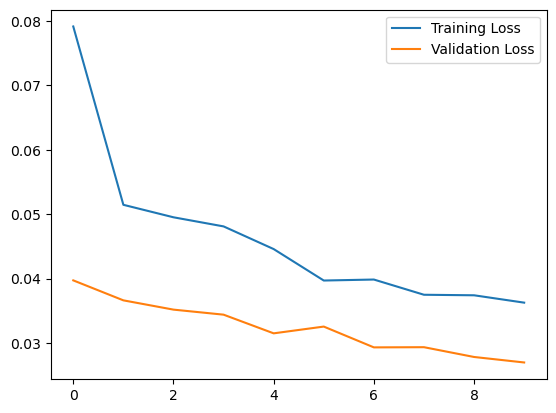

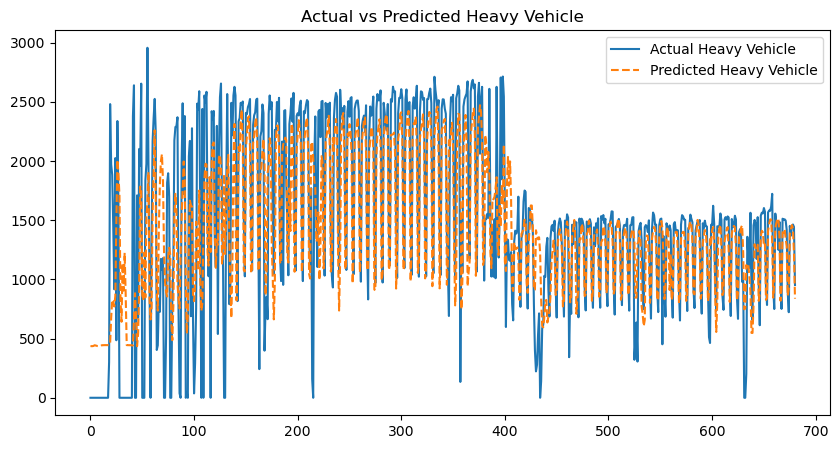

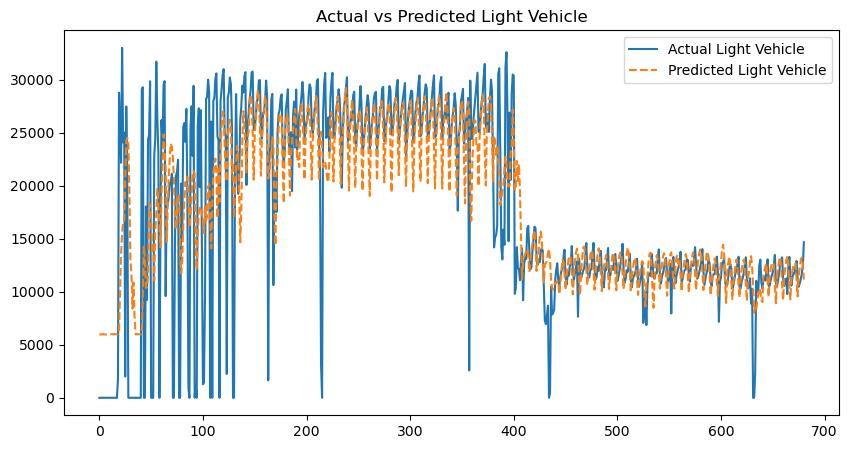

In [565]:

#import pandas as pd
#import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import datetime

#  Prepare the data
# Select the features to include in the model (in addition to 'heavy_vehicle' and 'light_vehicle')
features = ['heavy_vehicle', 'light_vehicle','RAIN_sum']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_data[features])  # Scale selected columns

# Create a new DataFrame with the scaled data and the same index
combined_data_scaled = pd.DataFrame(scaled_data, columns=features, index=combined_data.index)

#  Handle missing values
# Find the first missing value in either 'heavy_vehicle' or 'light_vehicle'
first_missing_index = combined_data[['heavy_vehicle', 'light_vehicle']].isnull().idxmax().max()

# Convert the first_missing_index to its integer location
first_missing_loc = combined_data.index.get_loc(first_missing_index)

# Filter data up to the first missing value
combined_data_filtered = combined_data_scaled.iloc[:first_missing_loc] 

# Create sequences (LSTM expects a 3D input: [samples, timesteps, features])
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Input sequence
        y.append(data[i, :2])           # Target for heavy_vehicle (0) and light_vehicle (1)
    return np.array(X), np.array(y)

# Define the sequence length and reshape the data for LSTM
sequence_length = 7  # 7-day sequences
data = combined_data_filtered.values  # Use scaled and filtered data with multiple features
X, y = create_sequences(data, sequence_length)

# Split the data into training and testing data
split_index = int(len(combined_data_filtered) * 0.8)  # Use 80% for training, 20% for testing

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define the LSTM model (with multiple input features and two outputs for heavy_vehicle and light_vehicle)
model = Sequential()
# Adjust input shape to account for the number of features (len(features))
model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, len(features))))  # Use all selected features
model.add(LSTM(64))
model.add(Dense(2))  # Predict two values at a time (for heavy_vehicle and light_vehicle)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model to predict both heavy_vehicle and light_vehicle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


# Predict on the test data
y_pred = model.predict(X_test)

# Apply MinMaxScaler only for heavy_vehicle and light_vehicle
scaler_vehicle = MinMaxScaler()
scaler_vehicle.fit(combined_data[['heavy_vehicle', 'light_vehicle']])  # Fit scaler on only these two columns

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values (for comparison)
y_pred_inverse = scaler_vehicle.inverse_transform(y_pred)
y_test_inverse = scaler_vehicle.inverse_transform(y_test)

# Calculate RMSE and MAE for both heavy_vehicle and light_vehicle (same as before)
rmse_heavy_vehicle = np.sqrt(mean_squared_error(y_test_inverse[:, 0], y_pred_inverse[:, 0]))
rmse_light_vehicle = np.sqrt(mean_squared_error(y_test_inverse[:, 1], y_pred_inverse[:, 1]))

mae_heavy_vehicle = mean_absolute_error(y_test_inverse[:, 0], y_pred_inverse[:, 0])
mae_light_vehicle = mean_absolute_error(y_test_inverse[:, 1], y_pred_inverse[:, 1])


# Traffic Prediction

In [566]:
import numpy as np
import pandas as pd

# Prepare to make rolling predictions from the first missing value until 8 days from today
today = pd.Timestamp.today()
days_to_predict = (today - first_missing_index).days + 8  # From first missing value to 8 days from today

# Prepare the last valid sequence for prediction
# Assume the model was trained on a sequence of 7 days and all features were used in training
last_sequence = combined_data_scaled.iloc[first_missing_loc-sequence_length:first_missing_loc].values
pred_input = np.array([last_sequence])

# Predict for all missing days and 8 days into the future (Rolling Forecast)
predictions_future = []
for _ in range(days_to_predict):
    # Predict one step ahead
    pred = model.predict(pred_input)
    predictions_future.append(pred[0])  # Store the prediction for the current step
    
    # Update pred_input by appending the prediction and removing the first timestep
    pred_input = np.append(pred_input[:, 1:, :], [[np.hstack([pred_input[0, -1, 2:], pred[0]])]], axis=1)

# Inverse transform the predictions ONLY for heavy_vehicle and light_vehicle
# Assuming the scaler was originally fitted only on 'heavy_vehicle' and 'light_vehicle' columns
predictions_future = np.array(predictions_future)

# Perform the inverse transform only on the 2 columns (heavy_vehicle, light_vehicle)
scaler_vehicle = MinMaxScaler()
scaler_vehicle.fit(combined_data[['heavy_vehicle', 'light_vehicle']])  # Fit the scaler only on relevant columns
predictions_future_scaled = scaler_vehicle.inverse_transform(predictions_future[:, :2])  # Inverse-transform only the 2 columns

# Create a DataFrame of the predicted values
predicted_dates = pd.date_range(start=first_missing_index, periods=days_to_predict)
predicted_values_df = pd.DataFrame(predictions_future_scaled, columns=['heavy_vehicle', 'light_vehicle'], index=predicted_dates)

# Update the original combined_data DataFrame with the predictions
combined_data.update(predicted_values_df)

# Display the updated DataFrame
#print(combined_data.loc[first_missing_index:])


1/1 [==============================] - 0s 33ms/step


/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 35ms/step
             CO_mean  HUMID_mean  NEPH_mean   NO_mean  NO2_mean  OZONE_mean  \
2024-09-01  0.137270   31.843417   0.058875 -0.001673  0.256140    3.054250   
2024-09-02  0.135443   29.808250   0.079292 -0.028163  0.086860    3.188738   
2024-09-03  0.151750   42.383500   0.083542  0.063050  0.559288    2.637529   
2024-09-04  0.275515   61.051917   0.279458  0.861777  1.337082    1.789696   
2024-09-05  0.267276   48.832208   0.256958  0.768037  1.220985    2.048054   
...              ...         ...        ...       ...       ...         ...   
2025-12-27       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-28       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-29       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-30       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-31       NaN         NaN        NaN       NaN       NaN         NaN   


# Air Quality Model

In [567]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Step 1: Prepare the data
features = ['TEMP_min', 'TEMP_max', 'RAIN_sum', 'WDR_mean', 'WSP_max', 'heavy_vehicle', 'light_vehicle']
target = ['CO_mean', 'NO2_mean', 'NO_mean', 'OZONE_mean', 'PM10_mean', 'PM2.5_mean', 'SO2_mean']

# Scale the features and target variables
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(combined_data[features])

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(combined_data[target])

# Combine the scaled features and targets into a single DataFrame
combined_data_scaled = pd.DataFrame(np.hstack([scaled_features, scaled_target]), 
                                    columns=features + target, 
                                    index=combined_data.index)

# Handle missing values
first_missing_index = combined_data[target].isnull().idxmax().max()
first_missing_loc = combined_data.index.get_loc(first_missing_index)

# Filter data up to the first missing value
combined_data_filtered = combined_data_scaled.iloc[:first_missing_loc]

# Create sequences (LSTM expects a 3D input: [samples, timesteps, features])
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :len(features)])  # Input sequence (features)
        y.append(data[i, len(features):])              # Target sequence (CO, NO2, etc.)
    return np.array(X), np.array(y)

# Define the sequence length (7-day sequences)
sequence_length = 7
data = combined_data_filtered.values
X, y = create_sequences(data, sequence_length)

# Split the data into training and testing sets
split_index = int(len(combined_data_filtered) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build and compile the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(LSTM(64))
model.add(Dense(len(target)))  # Output layer for the 7 target variables

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Inverse transform the predicted and actual values for comparison
y_pred_inverse = scaler_target.inverse_transform(y_pred)
y_test_inverse = scaler_target.inverse_transform(y_test)

# Calculate RMSE for each target variable
for i, target_name in enumerate(target):
    rmse = np.sqrt(mean_squared_error(y_test_inverse[:, i], y_pred_inverse[:, i]))
    print(f"RMSE ({target_name}): {rmse}")

# Save the model for the prediction step
model.save("lstm_air_quality_model.h5")
np.save("scaler_features.npy", scaler_features)
np.save("scaler_target.npy", scaler_target)


Epoch 1/20
 1/87 [..............................] - ETA: 7s - loss: 0.0620

/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


87/87 [==============================] - 4s 45ms/step - loss: 0.0127 - val_loss: 0.0075
Epoch 2/20
87/87 [==============================] - 4s 43ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 3/20
87/87 [==============================] - 4s 44ms/step - loss: 0.0087 - val_loss: 0.0068
Epoch 4/20
87/87 [==============================] - 4s 43ms/step - loss: 0.0085 - val_loss: 0.0068
Epoch 5/20
87/87 [==============================] - 4s 44ms/step - loss: 0.0083 - val_loss: 0.0070
Epoch 6/20
87/87 [==============================] - 4s 43ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 7/20
87/87 [==============================] - 4s 44ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 8/20
87/87 [==============================] - 4s 43ms/step - loss: 0.0082 - val_loss: 0.0068
Epoch 9/20
87/87 [==============================] - 4s 43ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 10/20
87/87 [==============================] - 4s 43ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 11/20
87/87 [=

# Rewrite Weather data

In [568]:
# Ensure both DataFrames have their indices in datetime format
combined_data.index = pd.to_datetime(combined_data.index)
df_7forecast_sydney.index = pd.to_datetime(df_7forecast_sydney.index)

# Overwrite only the rows in combined_data where the dates overlap with df_7forecast_sydney
# This will keep all existing data in combined_data except for the overlapping dates, which will be replaced
combined_data.update(df_7forecast_sydney)

# Optionally, sort the DataFrame by the index to ensure the data is in chronological order
combined_data = combined_data.sort_index()

# Drop the first row of the DataFrame if needed
combined_data = combined_data.iloc[1:]

# Find the last valid entry for 'heavy_vehicle'
last_entry_date = combined_data['heavy_vehicle'].last_valid_index()

# Forward fill NaN values for all columns up to the last valid entry for 'heavy_vehicle'
combined_data.loc[:last_entry_date] = combined_data.loc[:last_entry_date].fillna(method='ffill')



# Air Quality Prediction

In [571]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load the trained model and scalers
model = load_model("lstm_air_quality_model.h5")
scaler_features = np.load("scaler_features.npy", allow_pickle=True).item()
scaler_target = np.load("scaler_target.npy", allow_pickle=True).item()

# Rolling forecast function
def rolling_forecast(model, initial_sequence, n_days, scaler_features, scaler_target):
    rolling_predictions = []
    current_sequence = initial_sequence  # Start with the most recent sequence

    for _ in range(n_days):
        pred = model.predict(np.array([current_sequence]))[0]  # Predict on the current sequence
        rolling_predictions.append(pred)

        # Reshape the prediction to ensure it has compatible dimensions for concatenation
        pred_reshaped = pred[:len(features)].reshape(1, -1)  # Reshape prediction to 2D

        # Append the prediction to the sequence and remove the oldest time step
        next_input = np.vstack([current_sequence[1:], pred_reshaped])
        current_sequence = next_input

    rolling_predictions = np.array(rolling_predictions)
    return scaler_target.inverse_transform(rolling_predictions)  # Inverse transform the predictions

# Prepare for rolling predictions (using the last valid sequence)
last_sequence = combined_data_scaled.iloc[first_missing_loc-sequence_length:first_missing_loc][features].values

# Perform the rolling forecast for 8 days
rolling_predictions = rolling_forecast(model, last_sequence, 8, scaler_features, scaler_target)

# Create a DataFrame with the rolling predictions
predicted_dates = pd.date_range(start=first_missing_index, periods=8)
predicted_values_df = pd.DataFrame(rolling_predictions, columns=target, index=predicted_dates)

# Update the original combined_data DataFrame with the rolling predictions
combined_data.update(predicted_values_df)

# Display the updated DataFrame
#print(combined_data.loc[first_missing_index:])


1/1 [==============================] - 0s 37ms/step


/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 30ms/step
             CO_mean  HUMID_mean  NEPH_mean   NO_mean  NO2_mean  OZONE_mean  \
2024-10-11  0.238967   71.342545   0.136273  0.712942  0.967787    1.496767   
2024-10-12  0.252102   71.342545   0.136273  0.849331  1.053960    1.416216   
2024-10-13  0.249950   71.342545   0.136273  0.883703  1.087775    1.503002   
2024-10-14  0.244190   71.342545   0.136273  0.866960  1.098065    1.634626   
2024-10-15  0.237089   71.342545   0.136273  0.845757  1.099422    1.716965   
...              ...         ...        ...       ...       ...         ...   
2025-12-27       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-28       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-29       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-30       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-31       NaN         NaN        NaN       NaN       NaN         NaN   


# Categorise results

In [579]:
import pandas as pd

# Function to categorize based on the pollutant dictionary
def categorize_value(value, pollutant):
    for category, (low, high) in pollutant_categories[pollutant].items():
        if low <= value < high:
            return category
    return None

# Example pollutant_categories dictionary
pollutant_categories = {
    'CO': {'Good': (0, 1), 'Fair': (1, 2), 'Poor': (2, 5), 'Very Poor': (5, float('inf'))},
    'OZONE': {'Good': (0, 5.4), 'Fair': (5.5, 8), 'Poor': (8.1, 12), 'Very Poor': (12.1, float('inf'))},
    'PM10': {'Good': (0, 50), 'Fair': (50, 100), 'Poor': (100, 150), 'Very Poor': (150, float('inf'))},
    'PM2.5': {'Good': (0, 25), 'Fair': (25, 50), 'Poor': (50, 75), 'Very Poor': (75, float('inf'))},
    'SO2': {'Good': (0, 13.3), 'Fair': (13.4, 20), 'Poor': (20.1, 30), 'Very Poor': (30.1, float('inf'))}
}

# Example pollutant_mapping dictionary
pollutant_mapping = {
    'CO_mean': 'CO',
    'OZONE_mean': 'OZONE',
    'PM10_mean': 'PM10',
    'PM2.5_mean': 'PM2.5',
    'SO2_mean': 'SO2'
}

# Assuming your DataFrame contains the columns 'CO_mean', 'OZONE_mean', etc.
for pollutant in pollutants:
    pollutant_key = pollutant_mapping[pollutant]  # Use the correct pollutant name in the dictionary
    combined_data[f'{pollutant_key}'] = combined_data[pollutant].apply(lambda x: categorize_value(x, pollutant_key))

# Function to find the worst category for each row
def worst_category(row):
    categories = row[[f'{pollutant_mapping[pollutant]}' for pollutant in pollutants]]
    category_order = ['Very Poor', 'Poor', 'Fair', 'Good']
    for cat in category_order:
        if cat in categories.values:
            return cat
    return 'Good'

# Get today's date
today = pd.Timestamp.today().normalize()  # Normalize to get just the date (no time component)

# Filter the DataFrame for today and the next 6 days (including today)
next_7_days = combined_data[(combined_data.index >= today) & (combined_data.index < today + pd.Timedelta(days=7))].copy()

# Apply the categorization for the next 7 days and create the 'overall' column
next_7_days['overall'] = next_7_days.apply(worst_category, axis=1)

# Check if the 'overall' column exists, if not, create it in combined_data
if 'overall' not in combined_data.columns:
    combined_data['overall'] = None

# Merge the next 7 days back into the original DataFrame (including the 'overall' column)
combined_data.update(next_7_days)

# Ensure the new 'overall' column is properly added and displayed in the DataFrame
combined_data.loc[next_7_days.index, 'overall'] = next_7_days['overall']

# Display the result


# For streamlit

In [577]:
today = pd.Timestamp.today().normalize()

next_7_days = today + pd.Timedelta(days=7)

week_data = combined_data.loc[(combined_data.index >= today) & (combined_data.index <= next_7_days)]


In [ ]:
# Streamlit app: Sydney Air Quality Forecast
st.title("Sydney Air Quality Forecast")
st.subheader("Weather")

# Show Weather Data (TEMP_min, TEMP_max, RAIN_sum, forecast)
weather_columns = ['TEMP_min', 'TEMP_max', 'RAIN_sum', 'forecast']
st.write(week_data[weather_columns])

# Air Quality Subtitle
st.subheader("Air Quality")

# Function for color coding air quality
def color_air_quality(val):
    color = ''
    if val == 'Good':
        color = 'background-color: green'
    elif val == 'Fair':
        color = 'background-color: yellow'
    elif val == 'Poor':
        color = 'background-color: orange'
    elif val == 'Very Poor':
        color = 'background-color: red'
    return color

# Select the air quality columns to display
air_quality_columns = ['CO', 'OZONE', 'PM10', 'PM2.5', 'SO2', 'overall']

# Apply the color formatting
styled_df = week_data[air_quality_columns].style.applymap(color_air_quality)

# Display the styled DataFrame in Streamlit
st.write(styled_df)
